# Imports

In [ ]:
import random
from datetime import datetime
import numpy as np
import keras 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import seaborn as sns

import matplotlib.pyplot as plt

# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip '/content/drive/MyDrive/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (8).jp

# Hyperparameters Setup

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 2
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_EPOCHS = 20

# Model Setup

In [ ]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# load training and validating images from directory
train_set = tf.keras.preprocessing.image_dataset_from_directory(
                                          DF_TRAIN,
                                          validation_split = 0.2,
                                          subset = 'training',
                                          seed = 932,
                                          batch_size = BATCH_SIZE,
                                          image_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
                                          DF_TRAIN,
                                          validation_split = 0.2,
                                          subset = 'validation',
                                          seed = 343,
                                          batch_size = BATCH_SIZE,
                                          image_size = (IMAGE_SIZE, IMAGE_SIZE))

test_set  = tf.keras.preprocessing.image_dataset_from_directory(
                                          DF_TEST,
                                          seed = 654,
                                          batch_size = BATCH_SIZE,
                                          image_size = (IMAGE_SIZE, IMAGE_SIZE))

# STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
# STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


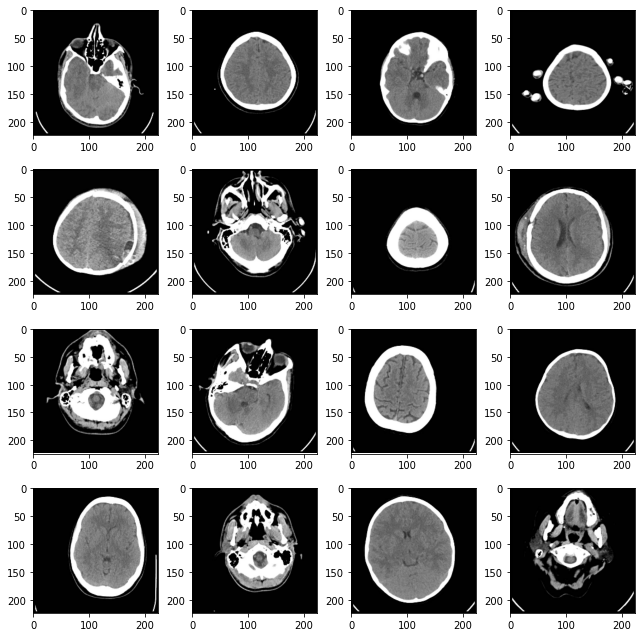

In [ ]:
# show images from dataset
fig, axes = plt.subplots(4, 4, figsize = (9, 9))
images = train_set.take(16)

axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img[0][0].numpy().astype("uint8"))
    # ax.set_xlabel(list(train_set.class_indices)[label.astype(int)])
plt.tight_layout()
plt.show()

In [ ]:
# add data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=None, fill_mode='reflect',
        interpolation='bilinear', seed=None, fill_value=0.0),
                layers.experimental.preprocessing.RandomCrop(height= 224, width = 224, seed=None),
    ]
)

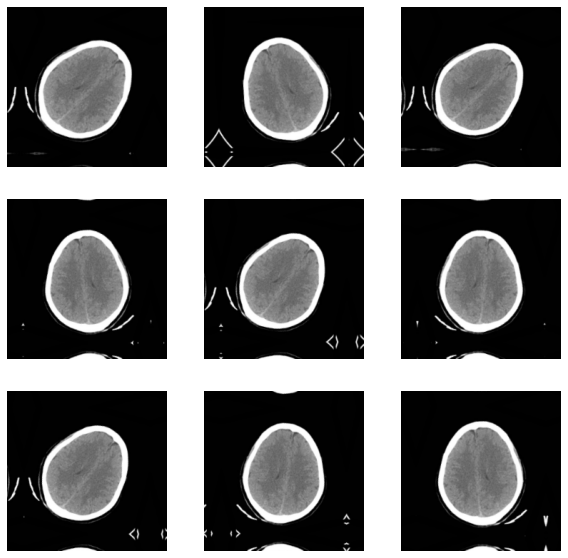

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Build Model

In [ ]:
# create DenseNet121 base model
base_model = tf.keras.applications.DenseNet121(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final'),
    ],
    name = 'densenet121_model')

model.summary()

# x = base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
# model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = METRICS)

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Final (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

# Train Model

In [ ]:
# train the model
callbacks = get_callbacks('dense121')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.5592 - tp: 387.0000 - fp: 187.0000 - tn: 948.0000 - fn: 279.0000 - BinaryAccuracy: 0.7413 - precision: 0.6742 - recall: 0.5811 - auc: 0.7928
Epoch 00001: val_loss improved from inf to 1.33116, saving model to model.dense121.h5
57/57 [==============================] - 18s 304ms/step - loss: 0.5592 - tp: 387.0000 - fp: 187.0000 - tn: 948.0000 - fn: 279.0000 - BinaryAccuracy: 0.7413 - precision: 0.6742 - recall: 0.5811 - auc: 0.7928 - val_loss: 1.3312 - val_tp: 84.0000 - val_fp: 46.0000 - val_tn: 241.0000 - val_fn: 79.0000 - val_BinaryAccuracy: 0.7222 - val_precision: 0.6462 - val_recall: 0.5153 - val_auc: 0.7891 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.3299 - tp: 519.0000 - fp: 115.0000 - tn: 1020.0000 - fn: 147.0000 - BinaryAccuracy: 0.8545 - precision: 0.8186 - recall: 0.7793 - auc: 0.9253
Epoch 00002: val_loss did not improve from 1.33116
57/57 [=============================

# Evaluate Model

In [ ]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 74ms/step - loss: 0.0213 - tp: 161.0000 - fp: 2.0000 - tn: 285.0000 - fn: 2.0000 - BinaryAccuracy: 0.9911 - precision: 0.9877 - recall: 0.9877 - auc: 0.9998


In [ ]:
# show results
print('DenseNet121:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

DenseNet121:
---------------
ACCURACY: 0.92
Binary Accuracy: 0.9200000166893005
Precision: 0.9487179517745972
Recall: 0.8880000114440918
AUC: 0.9617920517921448
F1 Score: 0.9173553794363908


# Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.48      0.58      0.53       125
      Stroke       0.47      0.37      0.41       125

    accuracy                           0.48       250
   macro avg       0.47      0.48      0.47       250
weighted avg       0.47      0.48      0.47       250

Confusion Matrix
[[73 52]
 [79 46]]


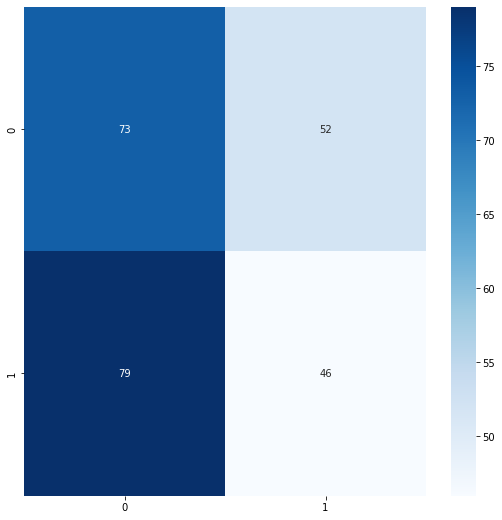

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix and classification report
data_to_test = test_set
Y_pred = model.predict(data_to_test)
y_pred = (Y_pred > 0.9).astype("int32")
# y_pred = np.argmax(Y_pred, axis = 1)
y_test = np.concatenate([y for x, y in data_to_test], axis=0)

print('\nClassification Report')
print(classification_report(y_test, y_pred, target_names = test_set.class_names))

confusionmatrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

In [ ]:
# create ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = METRICS)

In [ ]:
# train the model
callbacks = get_callbacks('resnet50')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.7215 - tp: 249.0000 - fp: 186.0000 - tn: 946.0000 - fn: 420.0000 - BinaryAccuracy: 0.6635 - precision: 0.5724 - recall: 0.3722 - auc: 0.6656
Epoch 00001: val_loss improved from inf to 174.92322, saving model to model.resnet50.h5
57/57 [==============================] - 23s 268ms/step - loss: 0.7215 - tp: 249.0000 - fp: 186.0000 - tn: 946.0000 - fn: 420.0000 - BinaryAccuracy: 0.6635 - precision: 0.5724 - recall: 0.3722 - auc: 0.6656 - val_loss: 174.9232 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 287.0000 - val_fn: 163.0000 - val_BinaryAccuracy: 0.6378 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.3527 - tp: 503.0000 - fp: 104.0000 - tn: 1028.0000 - fn: 166.0000 - BinaryAccuracy: 0.8501 - precision: 0.8287 - recall: 0.7519 - auc: 0.9178
Epoch 00002: val_loss improved from 174.92322 to 6.38498, saving mod

In [ ]:
# get results
results = model.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

8/8 [==============================] - 1s 65ms/step - loss: 0.1576 - tp: 122.0000 - fp: 6.0000 - tn: 119.0000 - fn: 3.0000 - BinaryAccuracy: 0.9640 - precision: 0.9531 - recall: 0.9760 - auc: 0.9840


In [ ]:
# show results
print('ResNet50:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ResNet50:
---------------
ACCURACY: 0.964
Binary Accuracy: 0.9639999866485596
Precision: 0.953125
Recall: 0.9760000109672546
AUC: 0.9839680790901184
F1 Score: 0.9644268828247076


Confusion Matrix
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 61 64]
 [ 0  0  0 ...  0 66 59]]

Classification Report
              precision    recall  f1-score   support

      Normal       0.48      0.49      0.48       125
      Stroke       0.48      0.47      0.48       125

    accuracy                           0.48       250
   macro avg       0.48      0.48      0.48       250
weighted avg       0.48      0.48      0.48       250



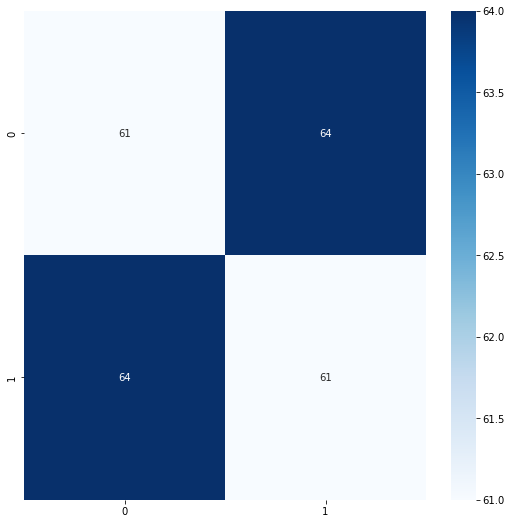

In [ ]:
# confusion matrix and classification report
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.8).astype("int32")
true_classes = np.concatenate([y for x, y in test_set], axis=0)

confusionmatrix = sklearn.metrics.confusion_matrix(true_classes, y_pred, labels = true_classes)
print('Confusion Matrix')
print(confusionmatrix)

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(true_classes, y_pred, target_names = target_names))

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

In [ ]:
# create VGG16 base model
base_model = tf.keras.applications.VGG16(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = METRICS)

In [ ]:
# train the model
callbacks = get_callbacks('vgg16')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 23.5381 - tp: 114.0000 - fp: 198.0000 - tn: 934.0000 - fn: 555.0000 - BinaryAccuracy: 0.5819 - precision: 0.3654 - recall: 0.1704 - auc: 0.4985
Epoch 00001: val_loss improved from inf to 0.68958, saving model to model.vgg16.h5
57/57 [==============================] - 23s 293ms/step - loss: 23.5381 - tp: 114.0000 - fp: 198.0000 - tn: 934.0000 - fn: 555.0000 - BinaryAccuracy: 0.5819 - precision: 0.3654 - recall: 0.1704 - auc: 0.4985 - val_loss: 0.6896 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 287.0000 - val_fn: 163.0000 - val_BinaryAccuracy: 0.6378 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.6882 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1131.0000 - fn: 669.0000 - BinaryAccuracy: 0.6280 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4985
Epoch 00002: val_loss improved from 0.68958 to 0.68583, saving mo

In [ ]:
# get results
results = model.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

8/8 [==============================] - 3s 423ms/step - loss: 0.7184 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 125.0000 - fn: 125.0000 - BinaryAccuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000


In [ ]:
results

{'BinaryAccuracy': 0.5,
 'auc': 0.5,
 'fn': 125.0,
 'fp': 0.0,
 'loss': 0.7183975577354431,
 'precision': 0.0,
 'recall': 0.0,
 'tn': 125.0,
 'tp': 0.0}

In [ ]:
# show results
print('VGG16:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
# print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

VGG16:
---------------
ACCURACY: 0.5
Binary Accuracy: 0.5
Precision: 0.0
Recall: 0.0
AUC: 0.5


Confusion Matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 125]]

Classification Report
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67       125
      Stroke       0.00      0.00      0.00       125

    accuracy                           0.50       250
   macro avg       0.25      0.50      0.33       250
weighted avg       0.25      0.50      0.33       250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


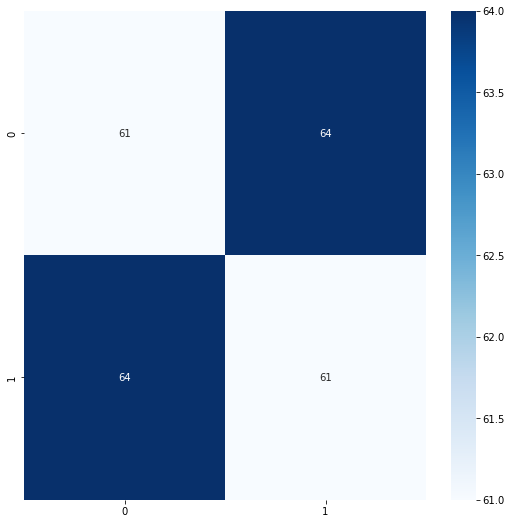

In [ ]:
# confusion matrix and classification report
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.8).astype("int32")
true_classes = np.concatenate([y for x, y in test_set], axis=0)

confusionmatrix = sklearn.metrics.confusion_matrix(true_classes, y_pred, labels = true_classes)
print('Confusion Matrix')
print(confusionmatrix)

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(true_classes, y_pred, target_names = target_names))

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)